# Main Analysis Pipeline
 
 * Prepare Hough transform based only on wire information (= energy, time, radial distance)
 * Build predictions based on Hough, local information, and local information of left/right neighbors 

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CyDetHits, CTHHits, CDCHits
from memory_profiler import memory_usage
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def flatten_data(data, keys, samples, n_features):
    return pandas.DataFrame(data=data[samples].reshape(-1, n_feats), columns=keys)

def mask(data, pol=None):
    if pol==None:
        return data[data['labels'] != 0]
    if pol==0:
        return data[(data['labels'] != 0) & (data['Polarity'] == 0)]
    if pol==1:
        return data[(data['labels'] != 0) & (data['Polarity'] != 0)]

def predict_classifier(classifier, data_samp):
    """
    Return predictions where no hit has zero response by definition.  Return both
    flat predictions, and event sorted predicitions
    """
    # Get the predictions
    pred_evt = classifier.predict_proba(data_samp)[:,1]

    # Check which wires have hits, which ones do not
    not_hit = (data_samp['labels'] == 0).values
    has_hit = (data_samp['labels'] != 0).values

    # Define hit-less wires as definitely not being signal
    pred_evt[not_hit] = 0

    # Slim down the result to a copy with only hits
    pred = pred_evt[has_hit]
    # Reshape the result to be the event shape, for the hoguh transform
    pred_evt = pred_evt.reshape(-1, geom.n_points)
    
    return pred, pred_evt

## Import Signal Hits

In [3]:
root_out_branches = ["px", "py", "pz", "x",  "y",  "z", "t"]
sig_cydet = CyDetHits('../data/151209_signal_tracks.root', 
                      signal_coding=[1], 
                      hit_type_name="tid",
                      branches=root_out_branches)
sig_cth = CTHHits('../data/151209_signal_tracks.root', 
                  signal_coding=[1], 
                  hit_type_name="tid")
sig = CDCHits(sig_cydet, sig_cth)

from cylinder import CyDet
geom = CyDet()
n_events = sig_cth.n_events

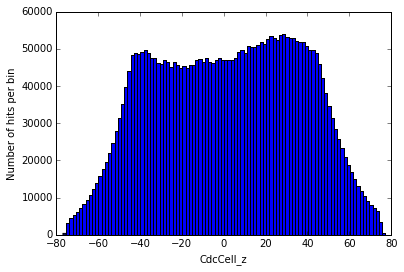

In [4]:
this_feat = "CdcCell_z"
plt.ylabel("Number of hits per bin")
plt.xlabel(this_feat)
plt.hist(sig_cydet.get_signal_hits()[this_feat], bins=100)
plt.show()

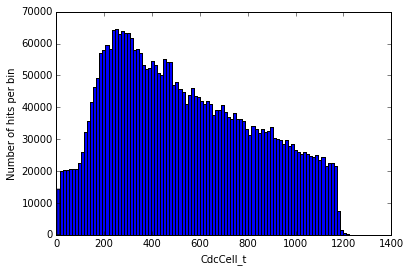

In [5]:
this_feat = "CdcCell_t"
plt.ylabel("Number of hits per bin")
plt.xlabel(this_feat)
plt.hist(sig_cydet.get_signal_hits()[this_feat], bins=100)
plt.show()

## Cuts on the Signal Tracks

In [6]:
# Define cuts to use
n_hits_cut = True
layer_cut = True
timing_cut = True
use_cth_cut = True

### Fiducial Time Window Cuts

In [7]:
if timing_cut:
    # Apply the timing filter
    print "CTH Hits: {}".format(sig.cth.n_hits)
    print "CyDet Hits: {}".format(sig.cydet.n_hits)
    sig.cth.trim_hits(variable=sig.cth.time_name, less_than=1170, greater_than=700)
    sig.cydet.trim_hits(variable=sig.cydet.time_name, less_than=1620, greater_than=700)
    print "CTH Hits: {}".format(sig.cth.n_hits)
    print "CyDet Hits: {}".format(sig.cydet.n_hits)

CTH Hits: 436987
CyDet Hits: 3678861
CTH Hits: 133438
CyDet Hits: 1948467


### Cuts on CTH

In [8]:
# Filter for CTH in time window.  Get the time
trigger_events = []
for evt in range(sig.n_events):
    sig_hits = sig.cth.get_signal_hits(evt)
    if len(sig_hits) != 0:
        trigger_events.append(evt)
trigger_events = np.array(trigger_events)
print "Events that pass CTH Trigger: {}".format(len(trigger_events))

Events that pass CTH Trigger: 15217


### Cuts on CyDet

In [9]:
# Filter for max layer is five
print "Start Events: {}".format(sig.n_events)
max_layer = []
for evt in range(sig.n_events):
    these_layers = sig.cydet.geom.point_layers[sig.cydet.get_sig_wires(evt)]
    if len(sig.cydet.get_sig_wires(evt)) != 0:
        max_layer.append(np.max(these_layers))
    else:
        max_layer.append(-1)
max_layer = np.array(max_layer)
good_max_layer = np.where(max_layer >= 4)[0]
print "End Events: {}".format(sig.n_events)

Start Events: 79587
End Events: 79587


In [10]:
# Filter for number of signal hits
print "Start Events: {}".format(sig.n_events)
n_signal_hits  = np.array([len(sig.cydet.get_signal_hits(evt)) 
                         for evt in range(sig.n_events)])
n_signal_hits = np.array(n_signal_hits)
good_n_hits = np.where(n_signal_hits >= 30)[0]
print "End Events: {}".format(sig.n_events)

Start Events: 79587
End Events: 79587


### Apply the cuts

In [11]:
# Apply quality and CTH cuts
print "Start Events: {}".format(sig.n_events)
passed_events = np.arange(sig.n_events)

if use_cth_cut:
    passed_events = np.intersect1d(passed_events, trigger_events)
    print "Removed due to CTH Trigger {}".format(sig.n_events - len(trigger_events))
if layer_cut:
    passed_events = np.intersect1d(passed_events, good_max_layer)
    print "Removed due to Layer Cut {}".format(sig.n_events - len(good_max_layer))
if n_hits_cut:
    passed_events = np.intersect1d(passed_events, good_n_hits)
    print "Removed due to N Hits Cut {}".format(sig.n_events - len(good_n_hits))

sig.trim_events(passed_events)
print "After All Cuts {}".format(sig.n_events)

Start Events: 79587
Removed due to CTH Trigger 64370
Removed due to Layer Cut 37524
Removed due to N Hits Cut 54997
After All Cuts 9733


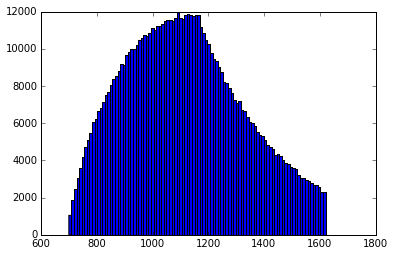

In [12]:
plt.hist(sig.cydet.data[sig.cydet.time_name], bins=100)
show()

## Prepare the data

In [13]:
import pandas
from tracking import HoughSpace
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve

In [14]:
hits_cydet = CyDetHits('../data/151208_SimChen_noise.root', signal_coding=[1], 
                       branches=root_out_branches)
hits_cth = CTHHits('../data/151208_SimChen_noise.root', signal_coding=[1])
hits = CDCHits(hits_cydet, hits_cth)

In [15]:
hits_cydet.all_branches

['CdcCell_px',
 'CdcCell_py',
 'CdcCell_pz',
 'CdcCell_x',
 'CdcCell_y',
 'CdcCell_z',
 'CdcCell_t',
 'CdcCell_hittype',
 'CdcCell_nHits',
 'CdcCell_hits_index',
 'CdcCell_event_index',
 'CdcCell_vol_id',
 'CdcCell_edep',
 'CdcCell_tstart',
 'CdcCell_mt']

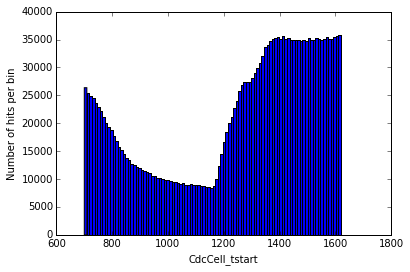

In [16]:
this_feat = "CdcCell_tstart"
plt.ylabel("Number of hits per bin")
plt.xlabel(this_feat)
plt.hist(hits_cydet.get_background_hits()[this_feat], bins=100)
plt.show()

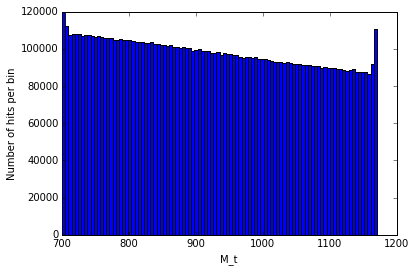

In [17]:
this_feat = "M_t"
plt.ylabel("Number of hits per bin")
plt.xlabel(this_feat)
plt.hist(hits_cth.get_background_hits()[this_feat], bins=100)
plt.show()

In [18]:
print max((hits_cth.get_background_hits()[this_feat]))

1169.99997062


In [19]:
n_events = min(sig.n_events, hits.n_events)
    
hits.trim_events(range(n_events))
sig.trim_events(range(n_events))

In [20]:
if timing_cut:
    # Apply the timing filter
    print "CTH Hits: {}".format(hits.cth.n_hits)
    print "CyDet Hits: {}".format(hits.cydet.n_hits)
    hits.cth.trim_hits(variable=hits.cth.time_name, less_than=1170, greater_than=700)
    hits.cydet.trim_hits(variable=hits.cydet.time_name, less_than=1620, greater_than=700)
    print "CTH Hits: {}".format(hits.cth.n_hits)
    print "CyDet Hits: {}".format(hits.cydet.n_hits)

CTH Hits: 9816474
CyDet Hits: 2181683
CTH Hits: 9816474
CyDet Hits: 2181683


### Set the trigger time

In [21]:
# Set the trigger times
trig_time_evt = []
for evt in range(sig.n_events):
    sig_hits = sig.cth.get_signal_hits(evt)
    if len(sig_hits) != 0:
        this_trig_time = sig_hits[sig.cth.time_name][0]
        trig_time_evt.append(this_trig_time)
        sig.cydet.data[sig.cydet.trig_name][sig.cydet.event_to_hits[evt]] = this_trig_time
        hits.cydet.data[hits.cydet.trig_name][hits.cydet.event_to_hits[evt]] = this_trig_time

(array([ 730.,  700.,  645.,  638.,  611.,  536.,  510.,  513.,  461.,  406.]),
 array([  700.01885959,   747.01603201,   794.01320444,   841.01037686,
          888.00754929,   935.00472171,   982.00189414,  1028.99906657,
         1075.99623899,  1122.99341142,  1169.99058384]),
 <a list of 10 Patch objects>)

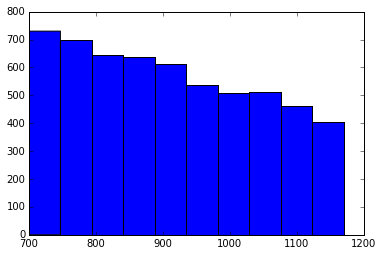

In [22]:
plt.hist(trig_time_evt)

In [23]:
right_neighs = numpy.array([hits.cydet.geom.shift_wire(wire, 1) for wire in range(hits.cydet.geom.n_points)])
left_neighs = numpy.array([hits.cydet.geom.shift_wire(wire, -1) for wire in range(hits.cydet.geom.n_points)])

In [24]:
from scipy.sparse import csr_matrix

In [25]:
# Energy deposits
deposits = numpy.vstack(hits.cydet.get_energy_deposits(i) \
                        + sig.cydet.get_energy_deposits(i) \
                        for i in range(n_events))
deposits *= 100 # to avoid small numbers for GBRT

In [26]:
# get hits on both
# find when signal came sooner
# subtract these from the backgroud mask

In [27]:
# Figure out coincidence
sig_time =  numpy.vstack(sig.cydet.get_hit_time(i)  for i in range(n_events)) # + 700.
hit_time =  numpy.vstack(hits.cydet.get_hit_time(i) for i in range(n_events))
# Flatten at first
sig_time = sig_time.flatten()
hit_time = hit_time.flatten()
# Find signal hits
sig_mask = sig_time != 0
# Find background hits
hit_mask = hit_time != 0
# Find coincidence
both = np.logical_and(sig_mask, hit_mask)
# Find when coincidence meant signal was sooner
sig_sooner = sig_time < hit_time
# Create masks for coincidence 
both_take_sig = np.logical_and(both, sig_sooner)
both_take_hit = np.logical_and(both, np.logical_not(sig_sooner))

In [28]:
print memory_usage()
del sig_time, hit_time
print memory_usage()

[3887.59765625]
[3690.9765625]


In [29]:
# Time after triggering that signal waveforms starts
sig_rel_time =  numpy.vstack(sig.cydet.get_relative_time(i)  for i in range(n_events))
hit_rel_time =  numpy.vstack(hits.cydet.get_relative_time(i) for i in range(n_events))
# Flatten at first
sig_rel_time = sig_rel_time.flatten()
hit_rel_time = hit_rel_time.flatten()
# Start with signal hit values, with the rest empty
rel_time = sig_rel_time + hit_rel_time
# Overlay masked background hits, where earlier signal hits are removed by mask
rel_time[both_take_sig] = sig_rel_time[both_take_sig]
rel_time[both_take_hit] = hit_rel_time[both_take_hit]
# Reshape back
rel_time = rel_time.reshape((n_events,-1))

In [30]:
print memory_usage()
del sig_rel_time, hit_rel_time
print memory_usage()

[3887.60546875]
[3690.984375]


In [31]:
# Get truth data about track momentum
entry_z = np.zeros(n_events)
entry_px = np.zeros(n_events)
entry_py = np.zeros(n_events)
entry_pz = np.zeros(n_events)

for i in range(n_events):
    these_sig = sig.cydet.get_signal_hits(i)
    first_hit = np.argmin(these_sig["CdcCell_t"])
    entry_z[i] = these_sig["CdcCell_z"][first_hit]
    entry_px[i] = these_sig["CdcCell_px"][first_hit]
    entry_py[i] = these_sig["CdcCell_py"][first_hit]
    entry_pz[i] = these_sig["CdcCell_pz"][first_hit]

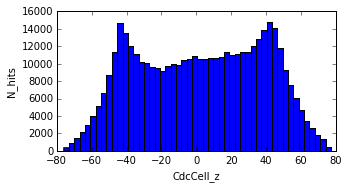

In [32]:
figsize(5,2.5)
all_sig = sig.cydet.get_signal_hits()
plt.hist(all_sig["CdcCell_z"], bins=50)
plt.xlabel("CdcCell_z")
plt.ylabel("N_hits")
plt.show()

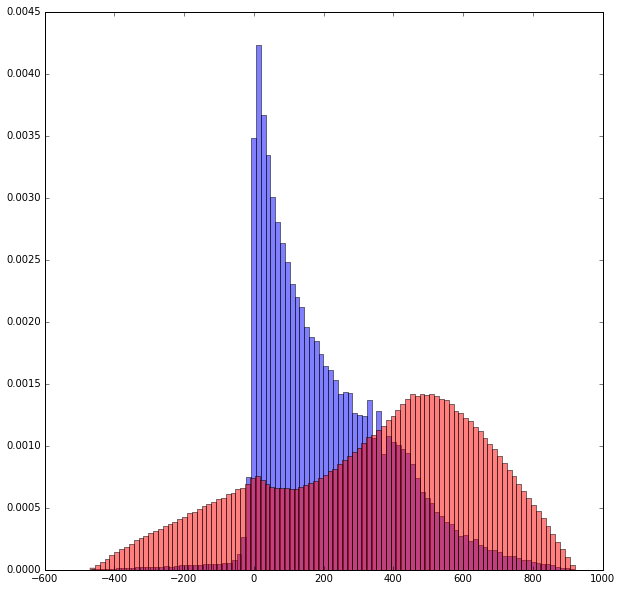

436222
2181683


In [33]:
figsize(10,10)
plt.hist(rel_time.flatten()[sig_mask], bins=100,  color='blue', alpha=0.5, normed=True)
plt.hist(rel_time.flatten()[hit_mask], bins=100,  color='red', alpha=0.5, normed=True)
show()
print len((rel_time.flatten()[sig_mask]))
print len((rel_time.flatten()[hit_mask]))

In [34]:
# Truth Values
sig_labels = numpy.vstack(sig.cydet.get_hit_types(i) for i in range(n_events))
hit_labels = numpy.vstack(hits.cydet.get_hit_types(i) for i in range(n_events)) 
# Flatten at first
sig_labels = sig_labels.flatten()
hit_labels = hit_labels.flatten()
# Define the overall relative time
labels =  hit_labels + sig_labels
# Factor in signal (and coincidence)
labels[both_take_sig] = sig_labels[both_take_sig]
labels[both_take_hit] = hit_labels[both_take_hit]
# Reshape bacl
labels = labels.reshape((n_events,-1))

In [35]:
# Layer ID of hit wires
layer_id = numpy.vstack(geom.point_rhos for i in range(n_events))

In [36]:
labels.shape, deposits.shape

((5750, 4482), (5750, 4482))

In [37]:
## Look up table to map from events to hits
event_to_hit_look = np.arange(n_events*geom.n_points).reshape(n_events, -1)

In [38]:
from sklearn.cross_validation import train_test_split
all_samples = range(labels.shape[0])
sample_3 = all_samples[:1917]
sample_2 = all_samples[1917:3834]
sample_1 = all_samples[3834:]
#rest, sample_3 = train_test_split(range(len(labels)), train_size=0.6, test_size=0.3)
#sample_1, sample_2 = train_test_split(rest, train_size=0.5, test_size=0.5)

In [39]:
root_output = pandas.DataFrame()

for feat in root_out_branches:
    print "Feature " + feat
    # Time after triggering that signal waveforms starts
    sig_feat =  numpy.vstack(sig.cydet.get_measurement(i, "CdcCell_"+feat) for i in range(n_events))
    hit_feat =  numpy.vstack(hits.cydet.get_measurement(i, "CdcCell_"+feat) for i in range(n_events))
    # Flatten at first
    sig_feat = sig_feat.flatten()
    hit_feat = hit_feat.flatten()
    # Start with signal hit values, with the rest empty
    all_feat = sig_feat + hit_feat
    # Overlay masked background hits, where earlier signal hits are removed by mask
    all_feat[both_take_sig] = sig_feat[both_take_sig]
    all_feat[both_take_hit] = hit_feat[both_take_hit]
    # Reshape back
    all_feat = all_feat.reshape((n_events,-1))
    # Only keep sample_3 for final output
    root_output[feat] = all_feat[sample_3].flatten()
    
    print memory_usage()
    del sig_feat, hit_feat, all_feat
    print memory_usage()

Feature px
[5067.5234375]
[4477.66015625]
Feature py
[5141.99609375]
[4552.1328125]
Feature pz
[5207.55078125]
[4617.6875]
Feature x
[5273.10546875]
[4683.2421875]
Feature y
[5338.66015625]
[4748.796875]
Feature z
[5404.21484375]
[4814.3515625]
Feature t
[5469.7734375]
[4879.91015625]


In [40]:
print memory_usage()
del sig, hits, sig_cydet, sig_cth, hits_cydet, hits_cth
print memory_usage()

[4879.91015625]
[3848.6953125]


In [41]:
import numpy, root_numpy
from rootpy.io import root_open

name_of_root = "track_finding.root"
root_numpy.array2root(root_output.to_records(), 'track_finding.root', mode='recreate')

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [42]:
print memory_usage()
del root_output
print memory_usage()

[3849.96484375]
[3456.63671875]


In [43]:
data_1, data_2, data_3 = pandas.DataFrame(), pandas.DataFrame(), pandas.DataFrame()

for data_samp, samp in zip([data_1, data_2, data_3],\
                           [sample_1, sample_2, sample_3]):
    # Deposit features
    data_samp['deposit'] = (deposits * 100)[samp].flatten()
    data_samp['r_deposit'] = (deposits * 100)[:, right_neighs][samp].flatten()
    data_samp['l_deposit'] = (deposits * 100)[:, left_neighs][samp].flatten()
    data_samp['layer_id'] = layer_id[samp].flatten()

In [44]:
print memory_usage()
del deposits, layer_id
print memory_usage()

[3456.63671875]
[3260.01953125]


In [45]:
for data_samp, samp in zip([data_1, data_2, data_3],\
                           [sample_1, sample_2, sample_3]):
    # Time feature
    data_samp['rel_time'] = rel_time[samp].flatten()
    data_samp['r_rel_time'] = rel_time[:, right_neighs][samp].flatten()
    data_samp['l_rel_time'] = rel_time[:, left_neighs][samp].flatten()

In [46]:
print memory_usage()
del rel_time
print memory_usage()

[3653.34765625]
[3653.34765625]


In [47]:
for data_samp, samp in zip([data_1, data_2, data_3],\
                           [sample_1, sample_2, sample_3]):
    # Truth values
    data_samp['labels'] = labels[samp].flatten()
    data_samp['is_signal'] =  numpy.take([0, 1, 0], labels.astype(int))[samp].flatten()

In [48]:
print memory_usage()
del labels
print memory_usage()

[3850.01171875]
[3653.390625]


In [49]:
print list(data_1.columns.astype(str))

['deposit', 'r_deposit', 'l_deposit', 'layer_id', 'rel_time', 'r_rel_time', 'l_rel_time', 'labels', 'is_signal']


In [50]:
# Define Data
train_features = list(data_1.columns[:-2])
n_feats = len(data_1.columns)
feature_labels = list(data_1.columns)

In [51]:
#data_1, data_2, data_3 = [flatten_data(numpy.dstack(features.values()),\
#                                       feature_labels, samp, n_feats)\
#                         for samp in [sample_1, sample_2, sample_3]]

In [52]:
entry_z_3 = entry_z[sample_3]
entry_px_3 = entry_px[sample_3]
entry_py_3 = entry_py[sample_3]
entry_pz_3 = entry_pz[sample_3]

del entry_z, entry_px, entry_py, entry_pz

## Classify Data

In [53]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc

In [54]:
factory = ClassifiersFactory()

# Define GBDT over neighbour-level features
neigh_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=train_features)
# Add the GBDT
factory.add_classifier('Local and Neighbour Features', neigh_gbdt)

In [55]:
# Train the classifier
factory.fit(mask(data_1), mask(data_1)['is_signal'])
pass

model Local and Neighbour Features was trained in 256.69 seconds
Totally spent 256.70 seconds on training


In [56]:
print memory_usage()
del data_1
print memory_usage()

[4246.59375]
[3656.9375]


In [57]:
# Print these predictions
pred_2, pred_evt_2 = predict_classifier(neigh_gbdt, data_2)

In [58]:
# Define which wires we want to correct as hits which were missclassified 
problem_weights_2 = (mask(data_2)['labels'] != 0) * abs(mask(data_2)['is_signal'] - pred_2) ** 2

In [59]:
print roc_auc_score(mask(data_2)['is_signal'], pred_2)
print roc_auc_score(mask(data_2)['is_signal'], pred_2, sample_weight=problem_weights_2)

0.990767808665
0.18161877737


In [60]:
from tracking import HoughSpace

default = [[31.5, 34, 34.5, 2]]
submatrices = []

# Define even and odd layer wires
even_wires = geom.point_pol != 1
odd_wires = geom.point_pol == 1

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = HoughSpace(geom, sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                       sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
    corresp = hough.correspondence
    submatrices.append(corresp)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [61]:
from tracking import HoughTransformer, HoughShifter
# Fit and transform the second data sample
hough_transformer = HoughTransformer(new_correspondence, \
                                     hough.norm_track_neighs,\
                                     pred_evt_2, alpha_max=2., alpha_rw=2.)

In [62]:
# Predict for third sample
pred_3, pred_evt_3 = predict_classifier(neigh_gbdt, data_3)

# Get the hough results
hough_result_2, hough_image_2 = hough_transformer.transform(pred_evt_2)
hough_result_3, hough_image_3 = hough_transformer.transform(pred_evt_3)

In [63]:
# Do the first transform to get the hough space that needs to be aligned
aligner = HoughTransformer(new_correspondence, hough.norm_track_neighs, pred_evt_2, alpha_rw=2., alpha_max=2.)
_ , to_align_2 = aligner.transform(pred_evt_2)
_ , to_align_3 = aligner.transform(pred_evt_3)

In [64]:
# Shift this hough space to get the even and odd layers agreeing
hough_shifter_2 = HoughShifter(hough, 10, -10)
hough_shifter_3 = HoughShifter(hough, 10, -10)

# Get the images
hough_image_even_3 = to_align_3[:,:hough.track.n_points]
hough_image_odd_3 = to_align_3[:,hough.track.n_points:]
# Fit the shifter
ideal_rotate_3, integral_even_3, integral_odd_3 =\
    hough_shifter_3.fit_shift(hough_image_even_3, hough_image_odd_3)
# Shift the result
shift_pred_evt_3 = hough_shifter_3.shift_result(pred_evt_3)
shift_labels_3 = hough_shifter_3.shift_result(data_3['labels'].reshape(-1, geom.n_points))

In [65]:
# Add these as features
data_2['Hough'] = hough_result_2.flatten()
data_3['Hough'] = hough_result_3.flatten()

In [66]:
# Add this to the feature list
train_features_full = train_features + ['Hough']

# Define the new classifier
hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=train_features_full) 

# Define GBDT over only energy deposit to compare
dep_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                               features=['deposit'])

# Ensure neigh-level GBDT has enough trees to compare properly
neigh_gbdt.set_params(n_estimators=200)

# Add the classifiers
factory.add_classifier('Hough, Local and Neighbour Features', hough_gbdt)
factory.add_classifier('Energy Deposition', dep_gbdt)

In [67]:
# Train the classifier
factory.fit(mask(data_2), mask(data_2)['is_signal'])
pass

model Local and Neighbour Features was trained in 529.87 seconds
model Hough, Local and Neighbour Features was trained in 294.44 seconds
model Energy Deposition was trained in 196.63 seconds
Totally spent 1020.94 seconds on training


In [68]:
# Test it on the last set of data
pred_final_diag_3 = factory.test_on(mask(data_3), mask(data_3)['is_signal'])
pred_final_3, pred_final_evt_3 = predict_classifier(hough_gbdt, data_3)
pred_3, pred_evt_3 = predict_classifier(neigh_gbdt, data_3)

In [69]:
# TODO clean this up
from collections import OrderedDict

figsize(6.4,6.4) 
feat_label_dict = OrderedDict([
            ('l_rel_time' , "Left Timing"),  
            ('r_rel_time' , "Right Timing"),
            ("layer_id" , "R Distance"), 
            ('r_deposit' , 'Right Energy'), 
            ('l_deposit' , 'Left Energy'), 
            ('rel_time' , "Timing"),
            ('deposit' , 'Energy'), 
            ('Hough' , r"Hough, $W_j''$")
    ])

def plot_feature_importance(rep_classifier, feat_label_dict):
    feat_import = rep_classifier.get_feature_importances()
    feat_import = feat_import.sort("effect", ascending=False)
    ax = plt.subplot(111)
    ax.bar( np.arange(len(feat_import.values)), feat_import.values,zorder=10)
    ax.set_xticks(np.arange(len(feat_import.values))+0.5)
    ax.minorticks_on()
    ax.set_ylabel("Normalized Relative Usage")
    ax.set_title("Feature Importance")
    ax.autoscale()
    ax.grid(b=True, which='major', axis='y' ,color='grey', linestyle='--')
    ax.grid(b=True, which='minor', axis='y' , color='grey', linestyle=':')
    ordered_labels = OrderedDict((key, feat_label_dict[key]) for key in feat_import.index.values)
    ax.set_xticklabels(ordered_labels.values(),  rotation='vertical')
    ax.set_yticklabels(["{:.0f}%".format(tick*100) for tick in ax.get_yticks()])
    return ax

def plot_feature_correlations(rep_factory, feat_label_dict):
    corr = pred_final_diag_3.features_correlation_matrix(features=train_features+["Hough"],
                                tick_labels=[feat_label_dict[key] for key in train_features_full])
    corr.fontsize = 15
    corr.cmap = "RdBu"
    return corr.plot()

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


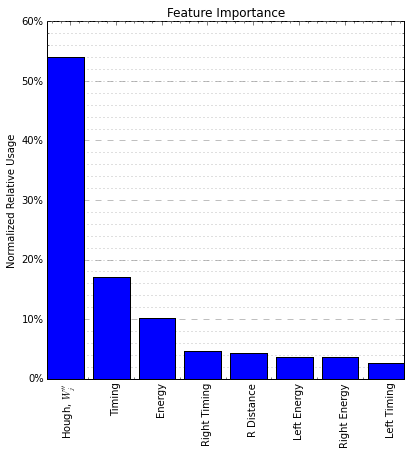

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


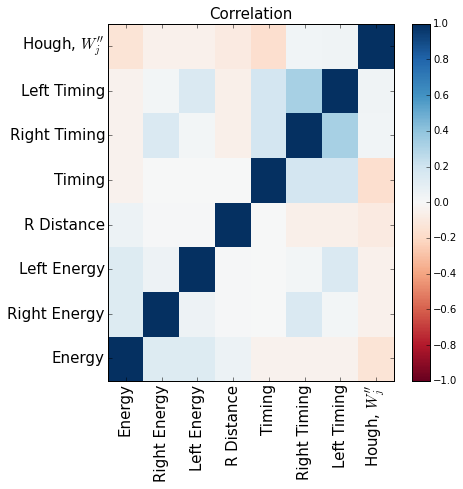

In [70]:
hough_level = factory["Hough, Local and Neighbour Features"]
plot_feature_importance(hough_level, feat_label_dict)
show()
plot_feature_correlations(factory, feat_label_dict)
show()

(<matplotlib.axes._subplots.AxesSubplot at 0x68f7a50>,
 <matplotlib.figure.Figure at 0xd6a99d0>)

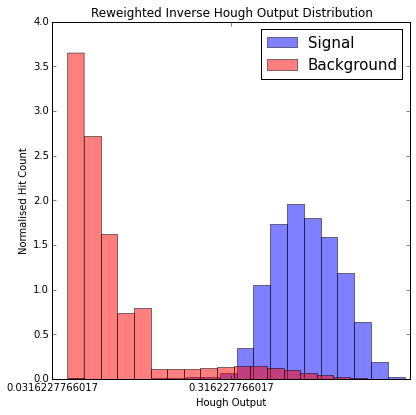

In [71]:
plot_feature( (data_3['Hough'].values+0.1), data_3['labels'].values, 
             xlabel="Hough Output", ylabel="Normalised Hit Count", xlog=True,
            title="Reweighted Inverse Hough Output Distribution", nbins=20)

In [72]:
print roc_auc_score(mask(data_3)['is_signal'], pred_final_3)

0.997396456791


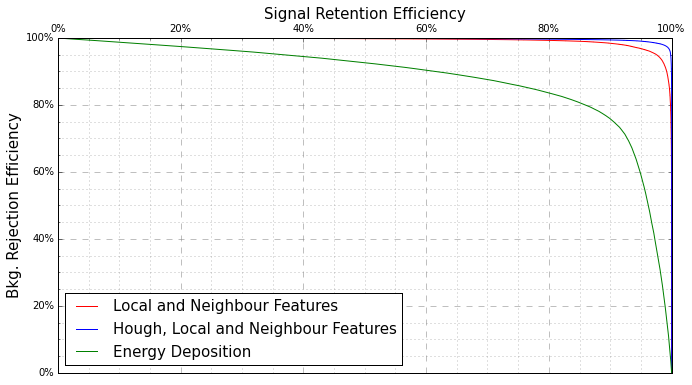

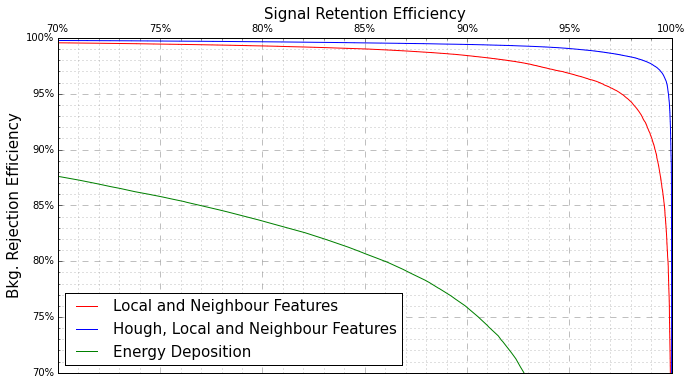

In [73]:
figsize(11,6) 
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=False)
#plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc.png", bbox_inches="tight")
show()
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=True)
#plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc_zoom.png", bbox_inches="tight")
show()

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


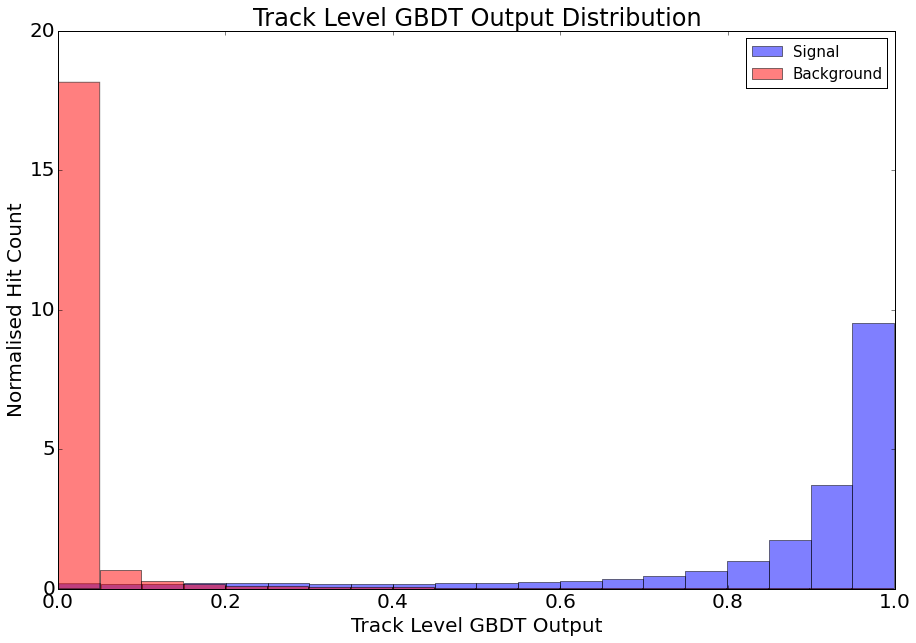

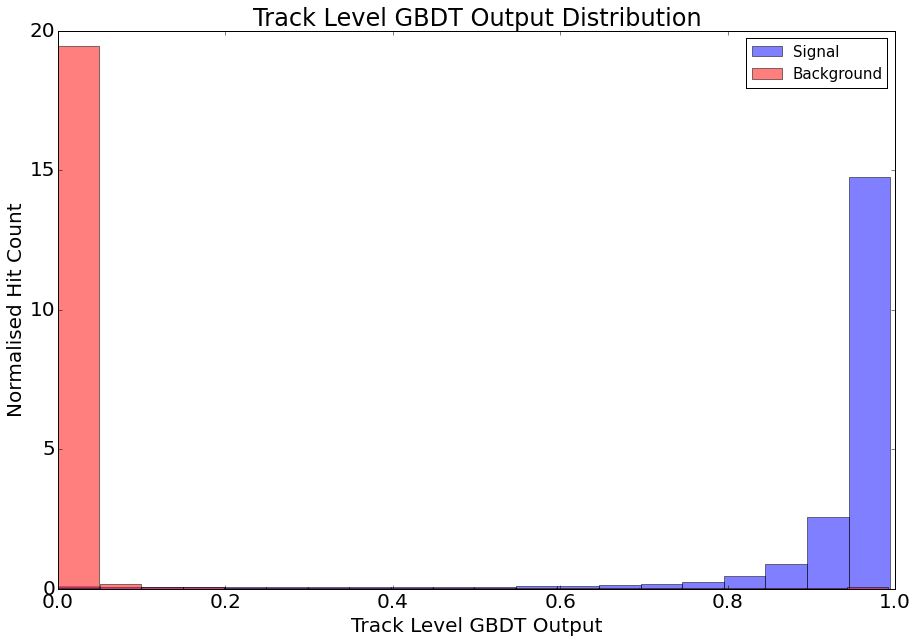

In [74]:
figsize(15,10)
plot_set_font(size=20)
plot_feature( pred_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count", 
            title="Track Level GBDT Output Distribution", nbins=20)
show()
plot_feature( pred_final_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count",
            title="Track Level GBDT Output Distribution", nbins=20)
show()

In [75]:
problem_weights_3 = (mask(data_3)['labels'] != 0) * abs(mask(data_3)['is_signal'] - pred_3) ** 2
print roc_auc_score(mask(data_3)['is_signal'], pred_3)
print roc_auc_score(mask(data_3)['is_signal'], pred_3, sample_weight=problem_weights_3)

0.992820753798
0.153461612011


In [76]:
from sklearn import linear_model
#print linear_model.LinearRegression__doc__
#print linear_model.RANSACRegressor.__doc__

In [77]:
# Get the actual circle parameters for the fit from the linearized parameters
def get_circle(x_coeff, y_coeff, intercept):
    return x_coeff/2, y_coeff/2, np.sqrt(4*intercept + x_coeff**2 + y_coeff**2)/2

In [78]:
# Check that the fit returns a circle that passes through the production target
def inside_target(model, X, y):
    a, b, r = get_circle(model.coef_[0][0], model.coef_[0][1], model.intercept_)
    return abs(np.sqrt(a**2 + b**2) - r) < 10

In [79]:
# Geometric considerations for the fit
wire_x, wire_y = geom.get_points_xs_and_ys()
# Linearize the input problem
wire_xy = np.vstack([wire_x, wire_y]).T
wire_z  = np.square(wire_x) + np.square(wire_y)

In [80]:
def ransac_fit(labels, preds, min_hits=13, plot=False, no_show=False):
    # Initialze parameters
    x1, y1, r1 = -1.*np.zeros(2), -1.*np.zeros(2), -1.*np.zeros(2)
    x2, y2, r2 = -1.*np.zeros(2), -1.*np.zeros(2), -1.*np.zeros(2)
    this_score = -1.*np.ones(wire_z.shape[0])
    
    # Get wires to fit
    even_sig = np.logical_and(even_wires, preds)
    odd_sig = np.logical_and(odd_wires, preds)
    
    # Plot the input to the fit
    if plot:
        plot_output(labels, geom, size=40*preds)
        plot_add_outlines(labels, geom)

    # Skip if either layer does not have enough hit points
    # if (sum(even_sig) < min_hits) or (sum(odd_sig) < min_hits):
    #     print "Skipped"
    #    if plot:
    #        show()
    #    return
    labels = np.zeros(geom.n_points)
    
    for pol, signal in enumerate([even_sig, odd_sig]):

        # Get the points to fit
        fit_x, fit_y = wire_x[signal], wire_y[signal]
        fit_xy = np.vstack([fit_x,fit_y]).T
        # Linearize the equation
        fit_z = np.square(fit_x) + np.square(fit_y)

        # Fit line using all data
        model = linear_model.LinearRegression()
        try:
            model.fit(fit_xy, fit_z)
        except ValueError:
            print "Skipped Normal"
            if plot:
                show()
            return None
        
        # Robustly fit linear model with RANSAC algorithm
        model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),
                                                   is_model_valid=inside_target,
                                                   max_trials=1000)
        try:
            model_ransac.fit(fit_xy, fit_z)
        except ValueError:
            print "Skipped RANSAC"
            if plot:
                show()
            return None
        
        # Give the unmasked values the inlier_mask_ values or logicial not
        inlier_mask = model_ransac.inlier_mask_
        outlier_mask = np.logical_not(model_ransac.inlier_mask_)
        
        # Plot the output
        labels[numpy.where(signal)[0][inlier_mask]] = 1
        labels[numpy.where(signal)[0][outlier_mask]] = 2
        
        # Get the regular fit
        x1[pol], y1[pol], r1[pol] = get_circle(model.coef_[0], model.coef_[1] , model.intercept_)

        # Get the RANSAC fit
        x2[pol], y2[pol], r2[pol] = get_circle(model_ransac.estimator_.coef_[0][0], 
                         model_ransac.estimator_.coef_[0][1] , model_ransac.estimator_.intercept_)

        # Make sure we're plotting all points
        #assert sum(labels == 1) + sum(labels == 2) == sum(signal),\
        #    "{} {}".format(sum(labels == 1) + sum(labels == 2), sum(signal))    
       
        #assert inlier_mask.count() + outlier_mask.count() == signal.count(),\
         #   "{} {}".format(inlier_mask.count() + outlier_mask.count(), signal.count())    
        if plot:
            plot_add_circle(x1[pol], y1[pol], r1[pol])
            print "Fit:" + str(r1[pol])
            plot_add_circle(x2[pol], y2[pol], r2[pol], color="red")
            print "RANSAC Fit:" + str(r2[pol]) + "\n"

        # Score the wires by distance from RANSAC
        this_score = model_ransac.estimator_.predict(wire_xy)[:,0]
        this_score -= wire_z
        this_score = np.absolute(this_score)
    if not no_show:
        show()
    return x1, y1, r1, x2, y2, r2, this_score, labels

In [147]:
print memory_usage()

[5899.765625]


In [149]:
# Define threshold GBDT output to fit to
for value in range(60,100):
    value = value/100.
    fpr, tpr, values =  roc_curve(mask(data_3)['is_signal'], pred_final_3)
    threshold = np.where(tpr > value)[0][0]
    print "{0:.8f}".format(tpr[threshold]),\
          "{0:.8f}".format(fpr[threshold]),\
          "{0:.8f}".format(values[threshold])

0.60000424 0.00161948 0.96155308
0.61000042 0.00166737 0.96072594
0.62000368 0.00171677 0.95983981
0.63000693 0.00175269 0.95898718
0.64000311 0.00180657 0.95801944
0.65000636 0.00186345 0.95704761
0.66000254 0.00191883 0.95591779
0.67000580 0.00201462 0.95471038
0.68000905 0.00207149 0.95344232
0.69000523 0.00214034 0.95207554
0.70000141 0.00222566 0.95058245
0.71000467 0.00229750 0.94895400
0.72000085 0.00236785 0.94726328
0.73000410 0.00246214 0.94536214
0.74000028 0.00257590 0.94333677
0.75000353 0.00271360 0.94117838
0.76002093 0.00283184 0.93867026
0.77000297 0.00295008 0.93610043
0.78000622 0.00308180 0.93333880
0.79000240 0.00323446 0.93006010
0.80000566 0.00338563 0.92648433
0.81000184 0.00354279 0.92243263
0.82000509 0.00373737 0.91820998
0.83000127 0.00393943 0.91359608
0.84000452 0.00412802 0.90831655
0.85000071 0.00437648 0.90228066
0.86000396 0.00460398 0.89550152
0.87000014 0.00486591 0.88754258
0.88000339 0.00511437 0.87836325
0.89000665 0.00546162 0.86683862
0.90000283

In [ ]:
  # Define the wires to be fit and their locations
    cut_pred_final_3 = pred_final_evt_3 > values[threshold]
    fit_evts = cut_pred_final_3.shape[0]

In [82]:
# Score the wires by distance from RANSAC
score = np.zeros(data_3['labels'].shape[0]) 
ransac_labels = np.zeros(data_3['labels'].shape[0]) 

even_circle = np.zeros((data_3['labels'].reshape(-1,geom.n_points).shape[0],3)) 
odd_circle = np.zeros((data_3['labels'].reshape(-1,geom.n_points).shape[0],3)) 

for evt in range(len(sample_3)):
#for evt in bad_ransac_events:
    if evt%100 == 0:
        print str(evt) + " ", 
    evt_hits = event_to_hit_look[evt]
    to_fit = data_3["labels"].values[evt_hits]
    output = ransac_fit(to_fit, cut_pred_final_3[evt,:])
    if output is not None:
        score[evt_hits] =  output[-2]
        # print  np.array(output[:-1])
        params =  np.array(output[3:-1]).flatten()
        even_circle[evt] = np.array(output[3:-2]).flatten()[::2]
        odd_circle[evt] = np.array(output[3:-2]).flatten()[1::2]
        ransac_labels[evt_hits] = output[-1]

data_3['score'] = score
data_3['ransac_labels'] = ransac_labels

0  Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
100  Skipped RANSAC
200  Skipped RANSAC
300  Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
400  Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
500  Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
600  Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
700  Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
800  Skipped RANSAC
Skipped RANSAC
Skipped Normal
Skipped RANSAC
Skipped RANSAC
Skipped Normal
Skipped RANSAC
900  Skipped RANSAC
Skipped RANSAC
Skipped Normal
Skipped RANSAC
Skipped RANSAC
1000  Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
1100  Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
1200  Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
1300  1400  Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped RANSAC
Skipped

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [83]:
print even_circle[10]
print odd_circle[10]
print entry_z_3[10]

[ 44.80371389  -3.61645093  30.45160759]
[ 44.49388567  -1.22877938  31.10002123]
26.5060343034


In [84]:
good_ransac_events = np.where(data_3['score'][1::4482] != 0)[0]
bad_ransac_events = np.where(data_3['score'][1::4482] == 0)[0]
n_total_ransac_events = data_3.shape[0]/4482

print n_total_ransac_events 
print len(good_ransac_events)
print len(bad_ransac_events)
print len(good_ransac_events)/float(n_total_ransac_events)
print bad_ransac_events

1917
1835
82
0.957224830464
[  17   31   38   65   95  188  207  315  317  325  362  396  406  432  437
  452  500  521  546  576  581  597  614  615  622  645  646  665  712  765
  769  807  809  822  855  857  868  891  904  920  938  971  973 1022 1049
 1057 1105 1127 1176 1180 1184 1198 1207 1216 1259 1406 1431 1436 1442 1447
 1473 1474 1513 1514 1516 1568 1606 1614 1617 1633 1641 1647 1652 1665 1674
 1680 1684 1705 1795 1818 1891 1916]


In [85]:
from scipy.spatial.distance import cdist
from numpy import unravel_index

n_sample_points = 1001

unit_x = np.cos(np.linspace(-np.pi, np.pi, n_sample_points))
unit_y = np.sin(np.linspace(-np.pi, np.pi, n_sample_points))

def crossing_points(circle_a, circle_b, circle_r, fiducial_radius):
    # Define the circle's points
    circle_x = circle_r * unit_x + circle_a
    circle_y = circle_r * unit_y + circle_b    
    
    # Check where these points are at the fiducial radius
    dist_to_fiducal = np.sqrt(np.square(circle_x) + np.square(circle_y)) - fiducial_radius
    max_dist_index = np.argmax(dist_to_fiducal)
    circle_x = np.roll(circle_x, -max_dist_index)
    circle_y = np.roll(circle_y, -max_dist_index)
    dist_to_fiducal = np.roll(dist_to_fiducal, -max_dist_index)
    
    inside_boundary = np.sign(dist_to_fiducal)
    at_boundary = ((np.roll(inside_boundary, -1) - inside_boundary) != 0).astype(int).nonzero()[0]

    try:
        assert len(at_boundary) == 2,\
           "Caution: {} crossing points were found!!"
        d_theta = np.abs(at_boundary[0] - at_boundary[1])/float(n_sample_points) * 2 * np.pi
        if d_theta > np.pi:
            d_theta = 2 * np.pi - d_theta
        # Return the x, y locations of all crossing points
        return circle_x[at_boundary], circle_y[at_boundary], d_theta, \
               np.arctan2(circle_y[at_boundary], circle_x[at_boundary])
    
    except AssertionError:
        return None    

In [86]:
# TODO Check X, Y at target Z

fiducial_radius = geom.r_by_layer[0] - (geom.r_by_layer[1] - geom.r_by_layer[0])/2.


diff_offset = np.zeros(n_total_ransac_events)
z_dist_1 = np.zeros(n_total_ransac_events)
z_dist_2 = np.zeros(n_total_ransac_events)
max_z = 73.5

dist_1 = np.zeros(n_total_ransac_events)
dist_2 = np.zeros(n_total_ransac_events)


bad_dist_evts = np.zeros(0)
avg_radius = np.zeros(n_total_ransac_events)
avg_d_theta = np.zeros(n_total_ransac_events)

counter = 0
counter_2 = 0


for nth_circ, circles in enumerate(zip(even_circle, odd_circle)): 

    counter_2 +=1 
    counter_3 = nth_circ
    
    e_circ = circles[0]
    o_circ = circles[1]
    
    # Sign is positive when even circle leads in phi around origin in clockwise direction
#    distance_sign = np.sign(np.arctan(o_circ[1]/o_circ[0]) - np.arctan(e_circ[1]/e_circ[0]))
    
    
    try: 
        e_crs_x, e_crs_y, e_d_theta, e_crs_angs = crossing_points(e_circ[0], e_circ[1], e_circ[2], fiducial_radius)
        o_crs_x, o_crs_y, o_d_theta, o_crs_angs = crossing_points(o_circ[0], o_circ[1], o_circ[2], fiducial_radius) 
    except TypeError:
        print "Crossing Error: ",
        print nth_circ
        bad_dist_evts = np.unique(np.append(bad_dist_evts, nth_circ))
        continue
    
    try:
        distances = cdist(zip(e_crs_x, e_crs_y), zip(o_crs_x, o_crs_y))
        ang_values = numpy.array([e_crs_angs[0] - o_crs_angs[0] ,\
                                  e_crs_angs[0] - o_crs_angs[1],\
                                  e_crs_angs[1] - o_crs_angs[0],\
                                  e_crs_angs[1] - o_crs_angs[1]]).reshape(2,2)
        #ang_values = (ang_values + 2*math.pi) % 2*math.pi
        ang_values = ang_values
    except ValueError: 
        print "PDist Error: ",
        print nth_circ,
        bad_dist_evts = np.unique(np.append(bad_dist_evts, nth_circ))
        print zip(e_crs_x, e_crs_y),
        print zip(o_crs_x, o_crs_y)
        continue
    
    if abs(e_d_theta - o_d_theta) > 0.1 * (e_d_theta + o_d_theta)/2.:
        print "Large d_theta disagreement", 
        print nth_circ,
        print e_d_theta, o_d_theta, 
        print e_circ[2], o_circ[2]
        
    if distances.argmin() != np.abs(ang_values).argmin():
        print "Angular Error {}".format(nth_circ)
        #print distances
        #print distances.argmin()
        #print ang_values
        #print ang_values.argmin()
        #print min_dist_idx
        #print tuple(np.logical_not(min_dist_idx).astype(int))
        if distances.argmin() + np.abs(ang_values).argmin() != 3:
            continue
    
    dist_1_idx = unravel_index(distances.argmin(), distances.shape)
    dist_2_idx = tuple(np.logical_not(dist_1_idx).astype(int))

    if not dist_1_idx[0] and dist_1_idx[1]:
        print nth_circ, dist_1_idx
        print " "
        
    dist_1[nth_circ] = ang_values[dist_1_idx]
    dist_2[nth_circ] = ang_values[dist_2_idx]
    
    z_dist_1[nth_circ] = geom.rel_z_at_theta(ang_values[dist_1_idx])*max_z
    z_dist_2[nth_circ] = geom.rel_z_at_theta(ang_values[dist_2_idx])*max_z
    
    avg_radius[nth_circ] = np.mean([e_circ[2], o_circ[2]])
    if avg_radius[nth_circ] == 0:
        print "Average error"
        print nth_circ
        print [e_circ[2], o_circ[2]]
    avg_d_theta[nth_circ] = np.max([e_d_theta, o_d_theta])
    
    counter += 1
    
print "counter 1 {}".format(counter)
print "counter 2 {}".format(counter_2)
print "counter 3 {}".format(counter_3)

print len(z_dist_2)
print np.setdiff1d(bad_dist_evts, bad_ransac_events)
bad_sample_3_evts = np.unique(np.append(bad_dist_evts, bad_ransac_events))
good_sample_3_evts = np.setdiff1d(range(len(sample_3)), bad_sample_3_evts)

Crossing Error:  17
Crossing Error:  31
Crossing Error:  38
Angular Error 51
Large d_theta disagreement 57 1.99605687081 2.21574866477 28.0849475843 30.1719309156
Crossing Error:  65
Large d_theta disagreement 79 2.17181030598 2.46682500072 36.1938295585 33.9164725205
Crossing Error:  95
Angular Error 111
Large d_theta disagreement 113 2.34756374114 1.82658034405 20.070241379 33.615277484
Large d_theta disagreement 136 2.11531813039 1.81402652725 20.5520019169 28.4463829545
Large d_theta disagreement 160 2.15297958078 1.5629501913 25.1835912113 64.8837770175
Crossing Error:  188
Large d_theta disagreement 193 2.02116450441 2.23457938997 26.6205164242 30.4840572297
Crossing Error:  207
Crossing Error:  315
Crossing Error:  317
Crossing Error:  325
Angular Error 347
Crossing Error:  362
Angular Error 369
Crossing Error:  396
Crossing Error:  406
Crossing Error:  432
Crossing Error:  437
Crossing Error:  452
Angular Error 455
Large d_theta disagreement 459 2.39150209994 2.81833187105 28.9

In [87]:
print len(np.nonzero(diff_offset)[0])
print len(good_sample_3_evts)

print len(bad_sample_3_evts)
print len(np.nonzero(diff_offset)[0]) +  len(bad_sample_3_evts)
print n_total_ransac_events
print len(entry_z_3)

0
1834
83
83
1917
1917


In [88]:
print len(avg_radius)

1917


In [89]:
print sum(avg_radius < 15.)

84


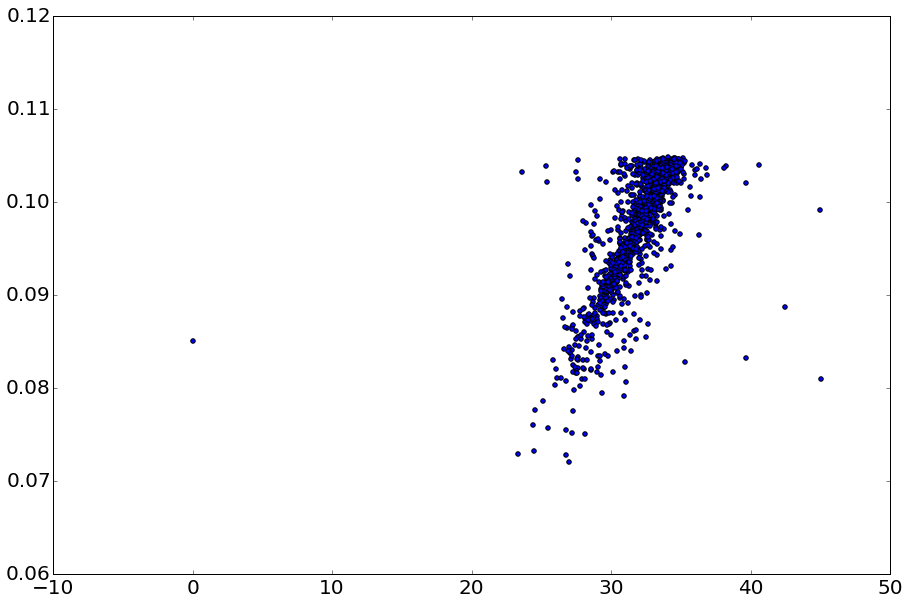

In [90]:
tras_momentum_3 = np.sqrt(np.square(entry_px_3) + np.square(entry_py_3))

plt.scatter(avg_radius[good_sample_3_evts], tras_momentum_3[good_sample_3_evts])

In [91]:
print sum(entry_pz_3 < 0)
print sum(entry_pz_3 > 0)

908
1009


In [92]:
z_1_diff = np.absolute(z_dist_1 - entry_z_3)
z_2_diff = np.absolute(z_dist_2 - entry_z_3)

z_1_better = z_1_diff < z_2_diff

In [93]:
z_best = np.array(z_dist_2)
z_best[z_1_better] = z_dist_1[z_1_better]

z_worst = np.array(z_dist_2)
z_best[np.logical_not(z_1_better)] = z_dist_1[np.logical_not(z_1_better)]

In [94]:
print z_dist_1
print z_dist_2
print z_best

[-25.42726209   2.97236817  11.45441689 ...,  23.82654634  -2.0352203    0.        ]
[-52.92817956 -47.02299971  25.94843216 ...,  27.48338423  -1.92204481   0.        ]
[-25.42726209   2.97236817  11.45441689 ...,  23.82654634  -2.0352203    0.        ]


[[ 1.          0.15142714]
 [ 0.15142714  1.        ]]


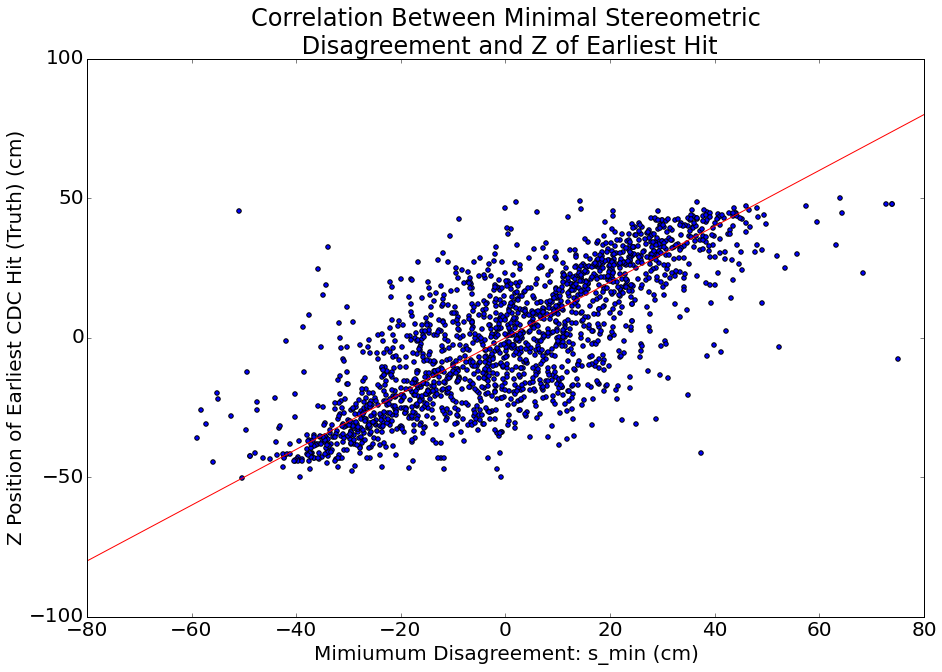

[[ 1.          0.15142714]
 [ 0.15142714  1.        ]]


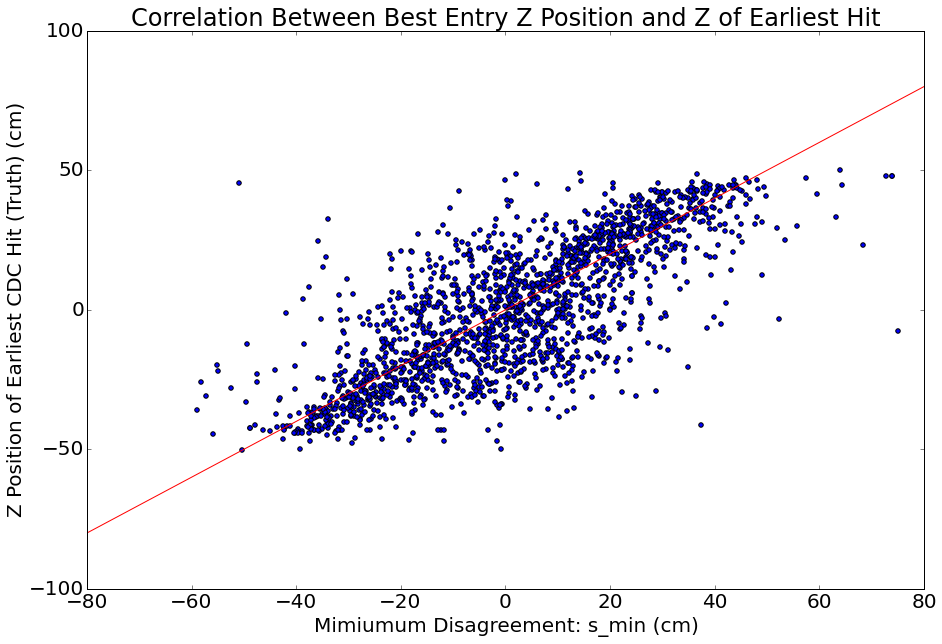

[[ 1.          0.57286463]
 [ 0.57286463  1.        ]]


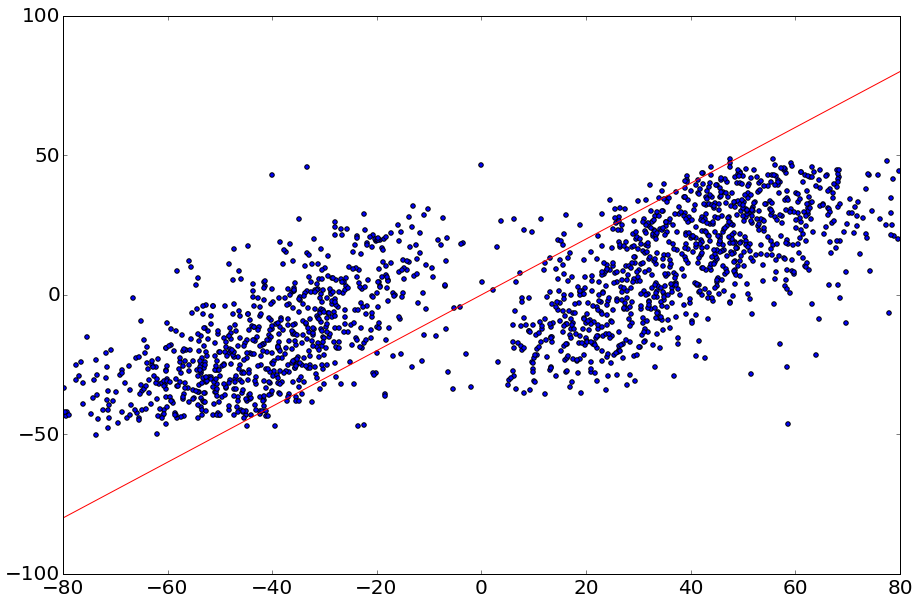

In [95]:
plt.xlim(-80,80)

x = np.linspace(-80,80)

plt.ylabel("Z Position of Earliest CDC Hit (Truth) (cm)")
plt.xlabel("Mimiumum Disagreement: s_min (cm) ")
plt.title("Correlation Between Minimal Stereometric\n Disagreement and Z of Earliest Hit")

plt.plot(x,x)
plt.scatter(z_dist_1[good_sample_3_evts], entry_z_3[good_sample_3_evts])
print numpy.corrcoef(z_dist_1[good_sample_3_evts], entry_z_3[good_sample_3_evts])
plt.show()

plt.xlim(-80,80)

plt.ylabel("Z Position of Earliest CDC Hit (Truth) (cm)")
plt.xlabel("Mimiumum Disagreement: s_min (cm) ")
plt.title("Correlation Between Best Entry Z Position and Z of Earliest Hit")

plt.plot(x,x)
plt.scatter(z_best[good_sample_3_evts], entry_z_3[good_sample_3_evts])
print numpy.corrcoef(z_best[good_sample_3_evts], entry_z_3[good_sample_3_evts])

#plt.savefig(savedir + "entry_z_correlation.png", bbox_inches='tight')

plt.show()
plt.xlim(-80,80)
print numpy.corrcoef(z_dist_2[good_sample_3_evts], entry_z_3[good_sample_3_evts])

plt.plot(x,x)
plt.scatter(z_dist_2[good_sample_3_evts], entry_z_3[good_sample_3_evts])
plt.show()

In [96]:
even_lead = np.sign(np.arctan(odd_circle[:,1]/odd_circle[:,0]) - np.arctan(even_circle[:,1]/even_circle[:,0]))
print sum(even_lead == -1)

830


In [97]:
diff_offset = z_dist_1 - z_dist_2

[[ nan  nan]
 [ nan   1.]]


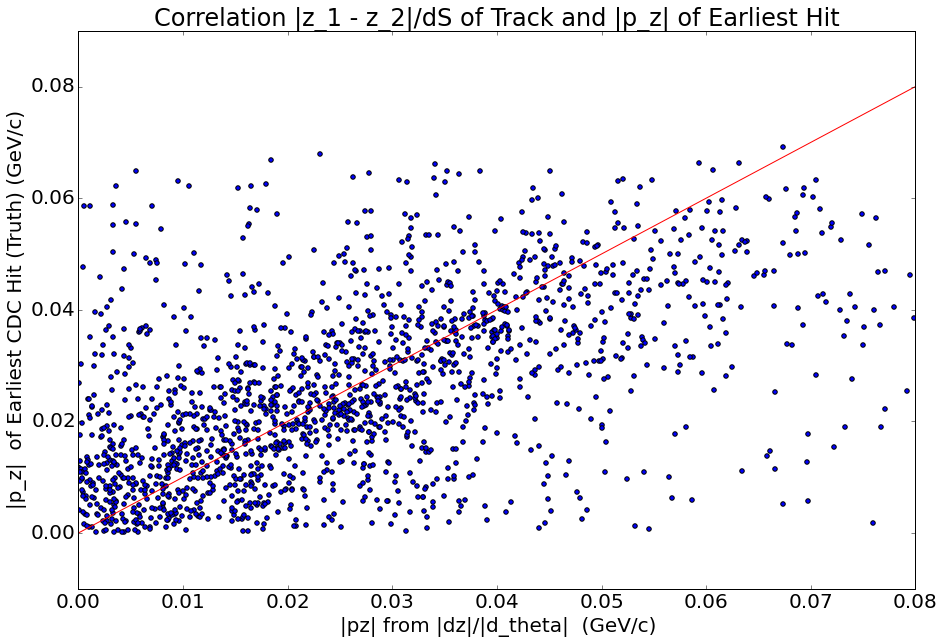

In [98]:
plt.xlim(0,0.08)
x_1 = np.linspace(0,0.08)

this_offset = np.absolute(diff_offset) * 0.002998
this_pz = np.absolute(entry_pz_3)

plt.plot(x_1,x_1)
plt.scatter(this_offset[good_sample_3_evts]/(avg_d_theta[good_sample_3_evts]), # * even_lead[good_sample_3_evts], 
            this_pz[good_sample_3_evts] )
print numpy.corrcoef(this_offset[good_sample_3_evts]/(avg_d_theta[good_sample_3_evts]), # * even_lead[good_sample_3_evts], 
            this_pz[good_sample_3_evts] )
plt.ylabel("|p_z|  of Earliest CDC Hit (Truth) (GeV/c)")
plt.xlabel("|pz| from |dz|/|d_theta|  (GeV/c) ")
plt.title("Correlation |z_1 - z_2|/dS of Track and |p_z| of Earliest Hit")
#plt.savefig(savedir + "p_z_correlation.png", bbox_inches='tight')
plt.show()


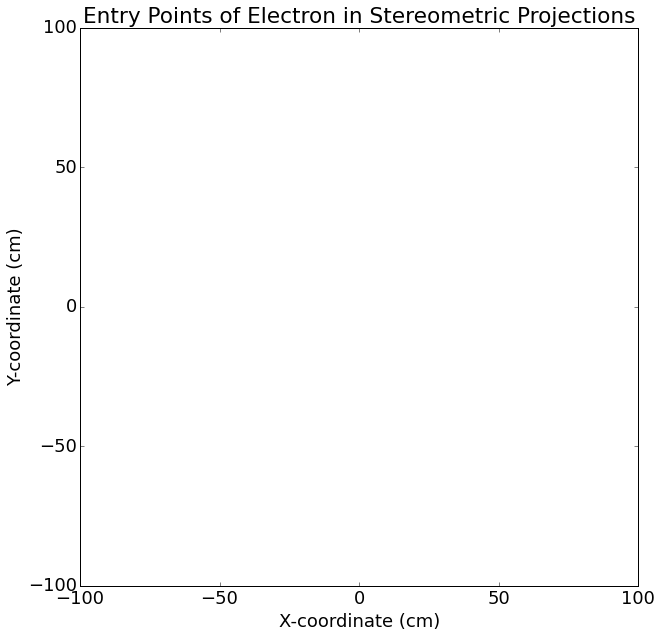

In [99]:
# TODO Check X, Y at target Z
plot_set_font(size=18)
figsize(10,10)
plt.xlim((-100,100))
plt.ylim((-100,100))
plt.xlabel("X-coordinate (cm)")
plt.ylabel("Y-coordinate (cm)")
plt.title("Entry Points of Electron in Stereometric Projections")

unit_x = np.cos(np.linspace(-np.pi, np.pi, 201))
unit_y = np.sin(np.linspace(-np.pi, np.pi, 201))


n_circles = 0
circle_0 = 0

fiducial_radius = geom.r_by_layer[0] - (geom.r_by_layer[1] - geom.r_by_layer[0])/2.
outer_radius = geom.r_by_layer[-1] + (geom.r_by_layer[1] - geom.r_by_layer[0])/2.
save_fits = True

for circle_n in range(circle_0,circle_0+n_circles):
    print circle_n
    big_circle_x = fiducial_radius * unit_x
    big_circle_y = fiducial_radius * unit_y
    bigger_circle_x = outer_radius * unit_x
    bigger_circle_y = outer_radius * unit_y

    plt.plot(big_circle_x, big_circle_y, c="red", ls="--", label="CDC Inner Radius")
    plt.plot(bigger_circle_x, bigger_circle_y, c="red", label="CDC Outer Radius")

    size_arc = 4
    begin_arc = 18
    this_arc_range = range(begin_arc,begin_arc+size_arc)
    plt.plot(big_circle_x[this_arc_range], big_circle_y[this_arc_range], color="DarkOrange", linewidth=5)
    
    min_dz = 18
    this_angle = 145/180. * np.pi
    this_r = 50
    #if this_label == "Even Layers":
    #    this_r *= -1
    next_x = np.cos(this_angle)*this_r
    next_y = np.sin(this_angle)*this_r
    plt.arrow(60, -82, next_x, next_y,
               head_width=3, head_length=5, color="black")
        
    big_theta = list()
    
    for this_n, this_color, this_label, this_circle in zip([0,1],
                                                   ["blue", "green"],
                                                   ["Even Layers", "Odd Layers"],
                                                   [even_circle[circle_n], odd_circle[circle_n]]):

        circle_r = this_circle[2]
        circle_x = circle_r * unit_x + this_circle[0]
        circle_y = circle_r * unit_y + this_circle[1]
        plt.plot(circle_x, circle_y, label=this_label, c=this_color)
        this_x, this_y, d_theta = crossing_points(this_circle[0], this_circle[1], this_circle[2], fiducial_radius) 
        
        
        plt.scatter(this_x, this_y)
        this_point = 165
        this_angle = 115/180. * np.pi
        this_r = 10
        if this_label == "Even Layers":
            this_r *= -1
        next_x = np.cos(this_angle)*this_r
        next_y = np.sin(this_angle)*this_r
        plt.arrow(circle_x[this_point], circle_y[this_point],
                  next_x, next_y,
                  head_width=3, head_length=5, color=this_color)
        #plt.scatter(circle_x[this_point], circle_y[this_point])
    
    plt.legend(fontsize=14)    
    #if save_fits:
        #plt.savefig(savedir + "stereo_fits.png", bbox_inches='tight')
    plt.show()


In [100]:
# Event information\
event = 1916
add_trans = True
save = True
savedir = "/vols/comet00/users/elg112/ICEDUST/track-finding-yandex/sakamoto_example/"

evt_hits = event_to_hit_look[event]
to_plot = data_3["labels"].values[evt_hits]
hough_output = data_3["Hough"].values[evt_hits]
plot_hough_image_3 = hough_image_3[event,:hough.track.n_points] + hough_image_3[event,hough.track.n_points:]

# Shifted plot information
shift_plot = shift_labels_3[event]

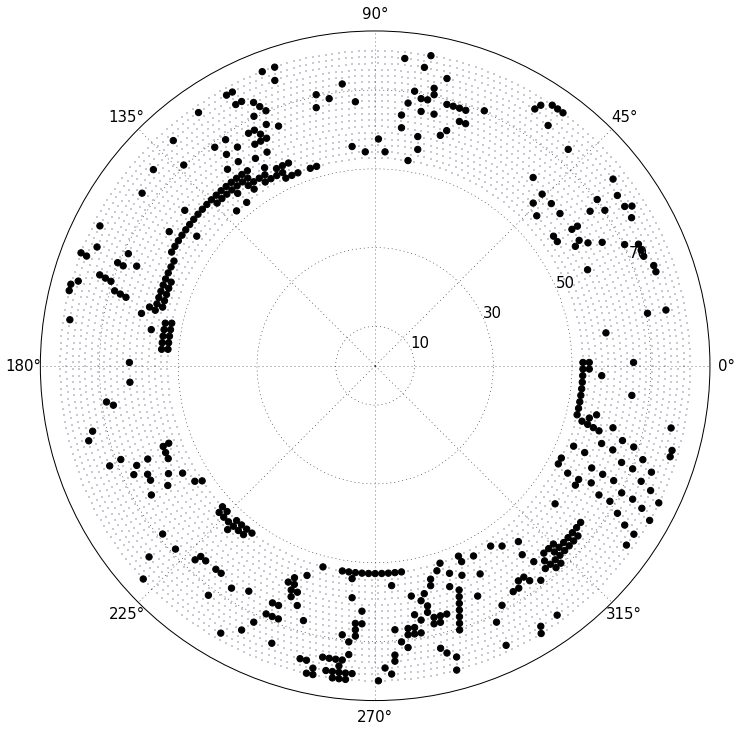

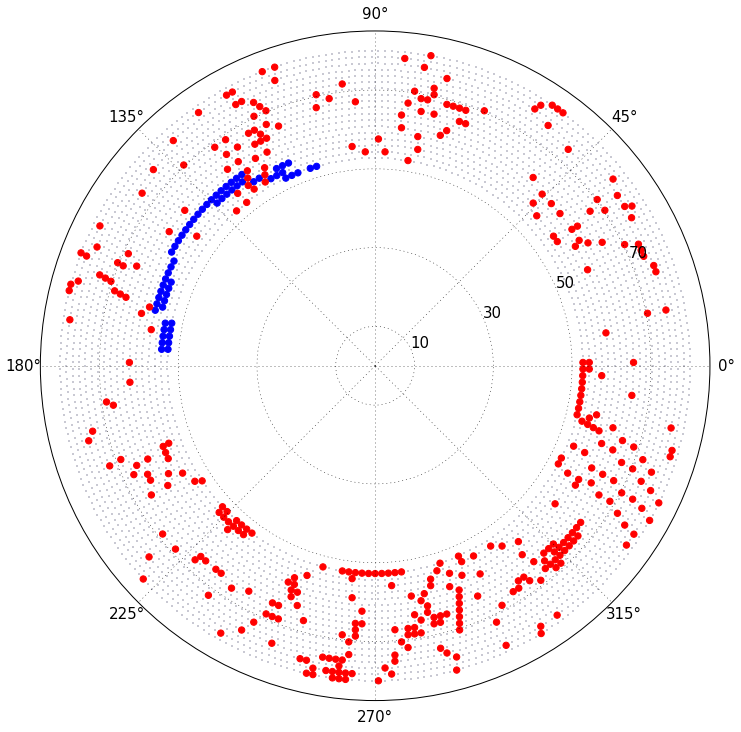

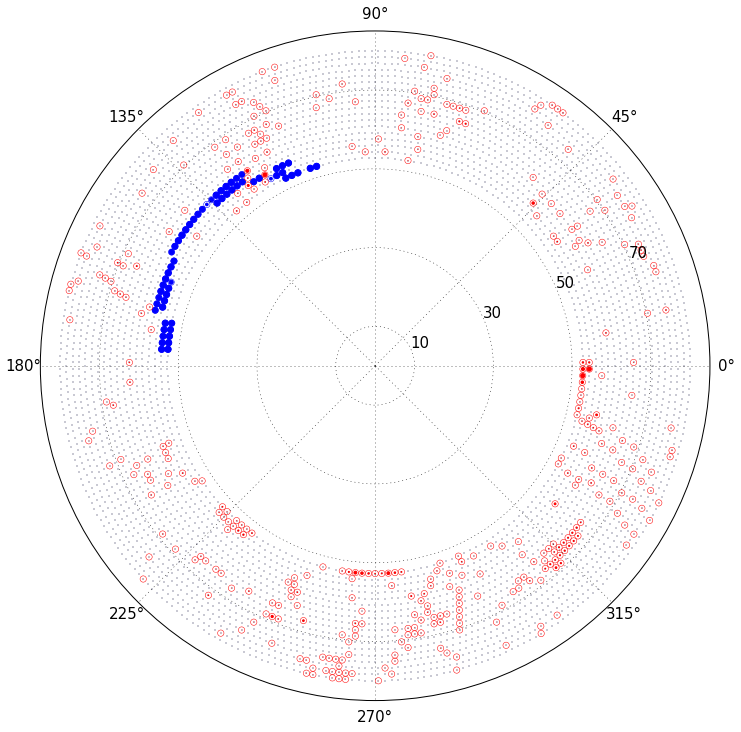

Length of draw tracks are 80


/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


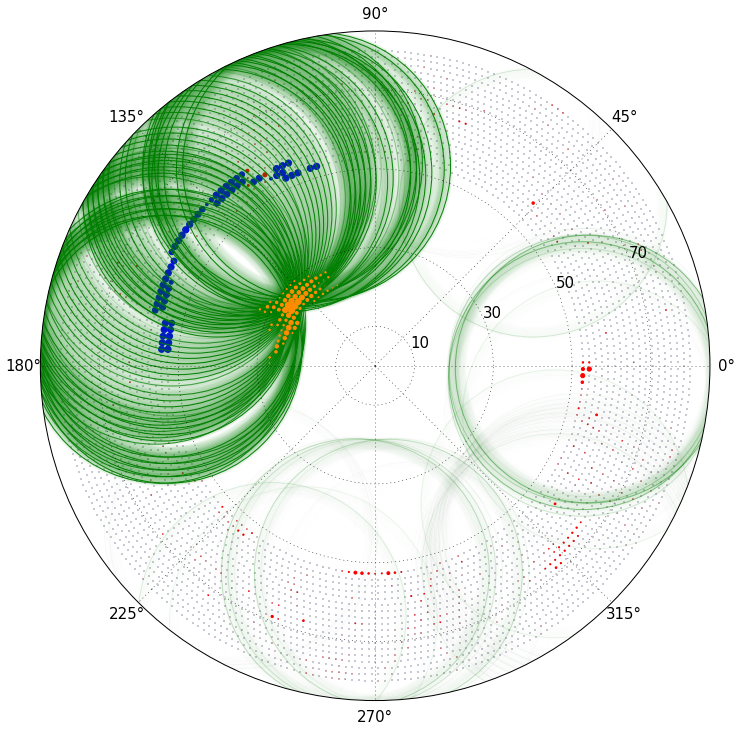

Length of draw tracks are 82


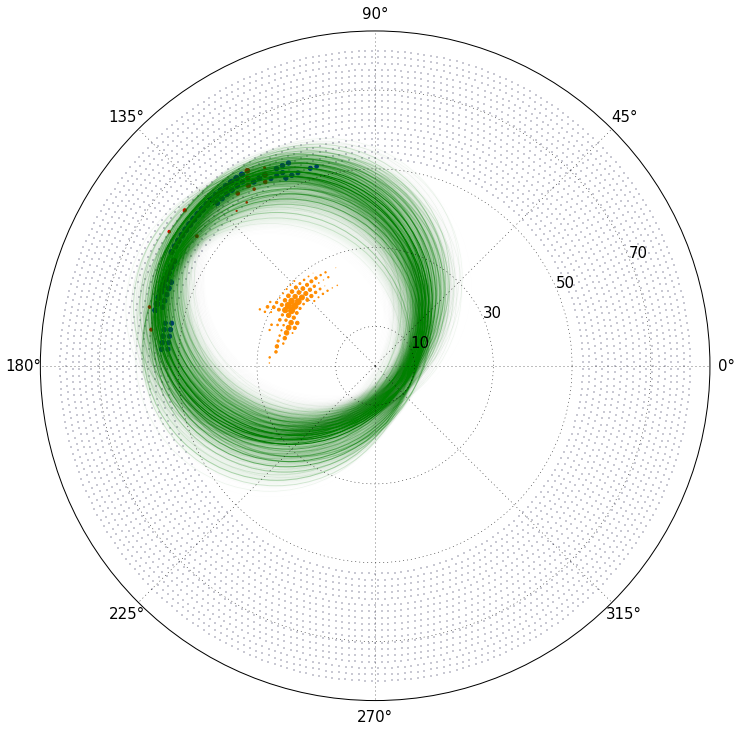

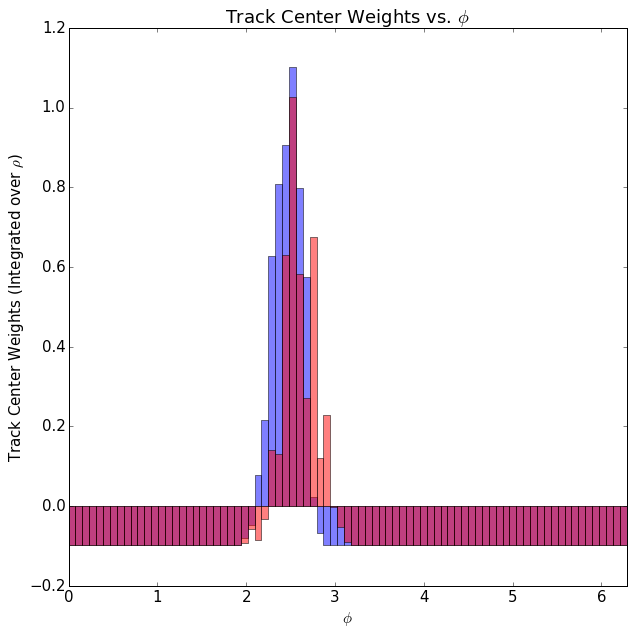

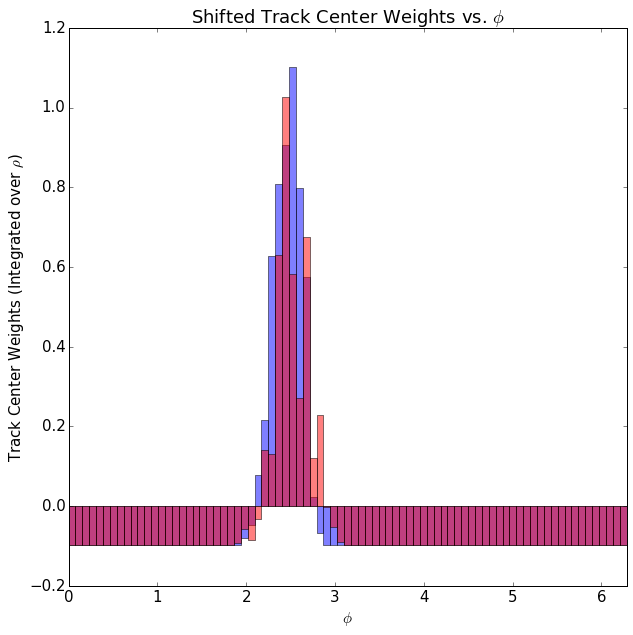

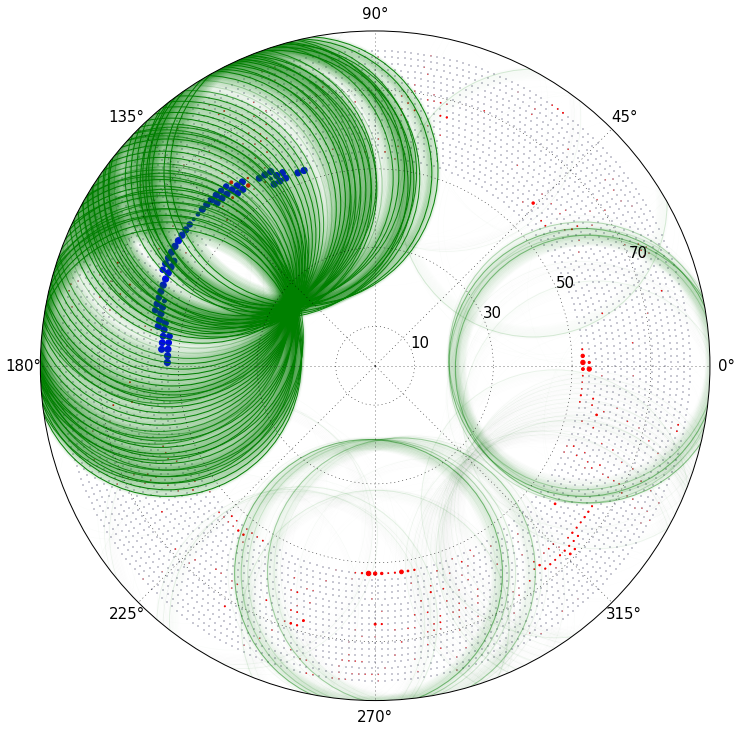

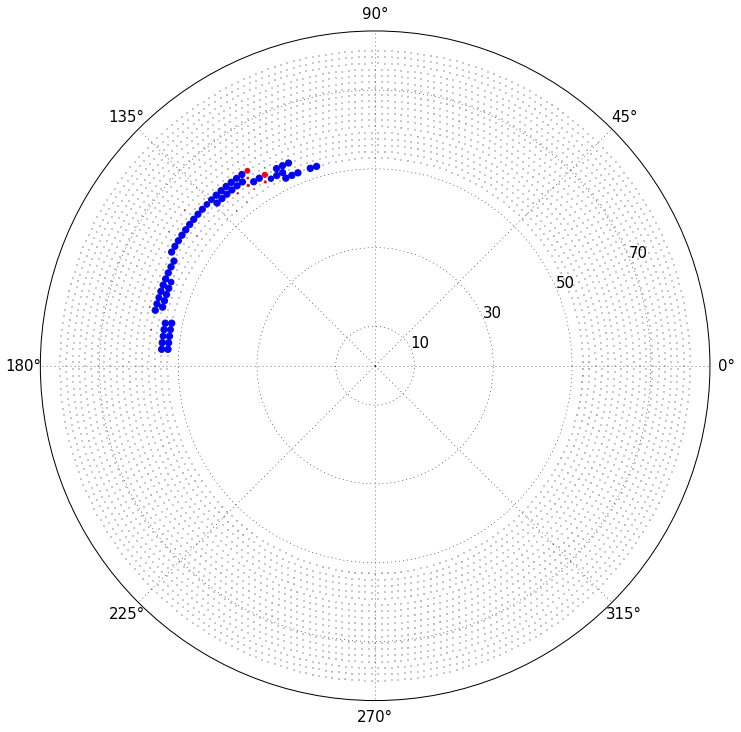

Fit:32.9578595374
RANSAC Fit:32.9578595374

Skipped RANSAC


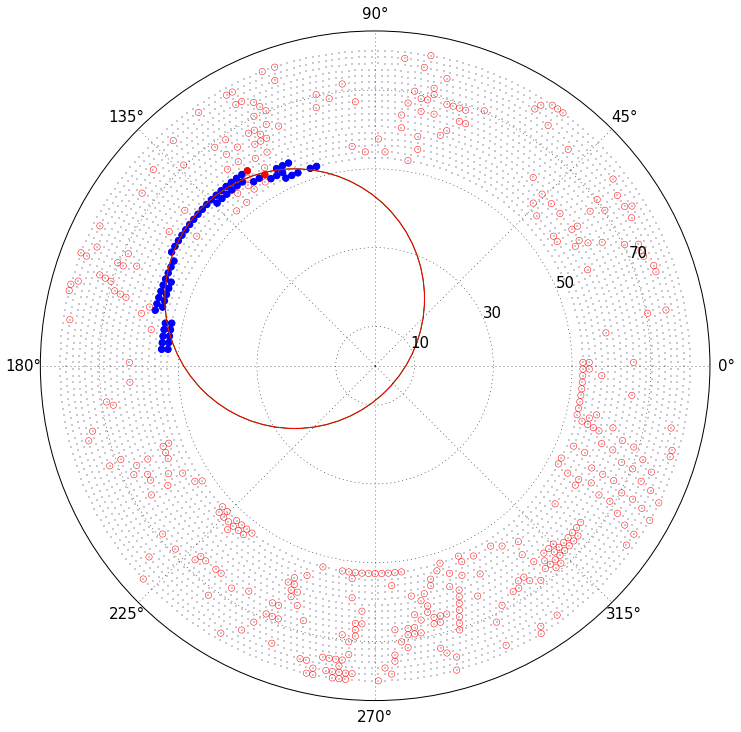

None


In [101]:
# Basic output
plot_output(to_plot, geom, sig_color='black', bkg_color='black', )
if save:
    plt.savefig(savedir+"plot_event_bw.png", bbox_inches='tight')
show()

plot_output(to_plot, geom)
if save:
    plt.savefig(savedir+"plot_event.png", bbox_inches='tight')
show()

# First GBDT output
plot_output(to_plot, geom, size=plot_norm_size(pred_evt_3[event,:]))
plot_add_outlines(to_plot, geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight')
show()

# Hough output
plot_output(to_plot, geom, size=plot_norm_size(pred_evt_3[event,:]), add_transform=add_trans)
plot_add_tracks(geom, hough, size=plot_norm_size(plot_hough_image_3,40))
if save:
    plt.savefig(savedir+"plot_hough.png", bbox_inches='tight')
show()

# Inverse Hough output
plot_output(to_plot, geom, size=plot_norm_size(hough_output))
plot_add_tracks(geom, hough, size=plot_norm_size(plot_hough_image_3,40), add_transform=add_trans,
                tolerance=0.00)
if save:
    plt.savefig(savedir+"plot_inv_hough.png", bbox_inches='tight')
show()    

# Shift in Hough Space
# TODO magic number here
plot_hough_shift(integral_even_3[event,:], integral_odd_3[event,:], 
                 hough_shifter_3.rotate_index[event]+hough_shifter_3.lower_lim)
show()

# Hough output
plot_output(shift_plot, geom, size=plot_norm_size(shift_pred_evt_3[event,:]), add_transform=add_trans)
#plot_add_tracks(geom, hough, size=plot_norm_size(shift_hough_image,40))
if save:
    plt.savefig(savedir+"plot_shft_hough.png",  bbox_inches='tight')
show()

# Inverse Hough output
#plot_output(shift_plot, geom, size=plot_norm_size(shift_hough_output))
#plot_add_tracks(geom, hough, size=plot_norm_size(shift_hough_image,40), add_transform=add_trans,
#                tolerance=0.00)
#if save:
#    plt.savefig(savedir+"plot_shft_inv_hough.png", bbox_inches='tight')
#show()

# Final
plot_output(to_plot, geom, size=plot_norm_size(pred_final_evt_3[event,:]))
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight')
show()

# RANSAC 
print ransac_fit(to_plot, cut_pred_final_3[event,:], plot=True)
if save:
    plt.savefig(savedir+"plot_ransac.png", bbox_inches='tight')
show()

Fit:32.9578595374
RANSAC Fit:32.9578595374

Skipped RANSAC


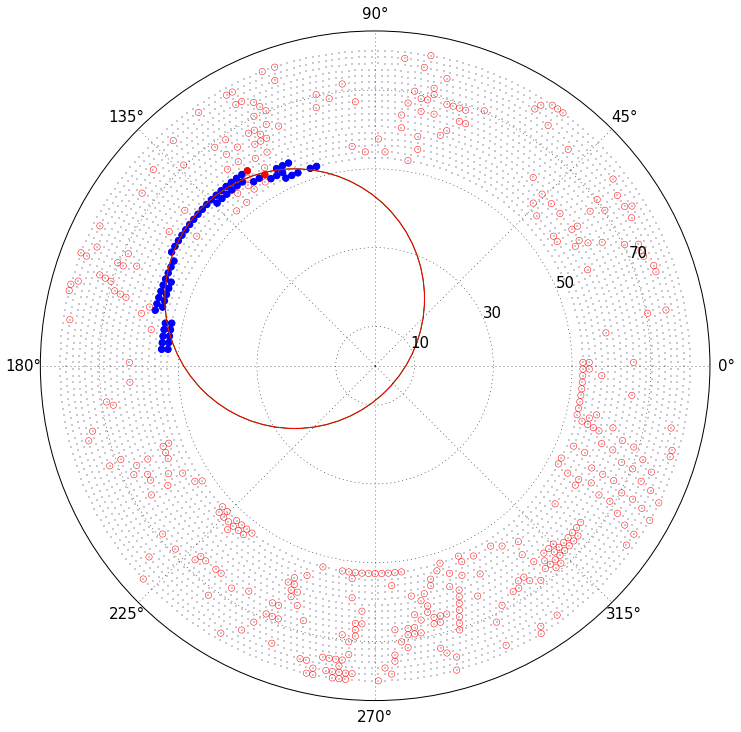

None


In [102]:
# RANSAC 
figsize(10,10)
print ransac_fit(to_plot, cut_pred_final_3[event,:], plot=True, no_show=True)
if save:
    plt.savefig(savedir+"plot_ransac.png", bbox_inches='tight')
plt.show()


In [103]:
memory_usage()

[4607.171875]

In [104]:
memory_usage()

[4607.171875]

In [105]:
root_output = pandas.DataFrame()

In [106]:
print len(cut_pred_final_3)

1917


In [107]:
for name, value in zip(['labels', 'cell_id', 'layer_id', 'wire_id', 'event_id', 'cut_preds'],
                        [data_3['labels'], 
                         (np.arange(len(data_3['labels'])) % 4482),
                         np.concatenate( [geom.point_layers] * len(sample_3) ),
                         (np.arange(len(data_3['labels'])) % 4482) - \
                         np.concatenate( [geom.first_point[geom.point_layers]] * len(sample_3) ), 
                        (np.arange(len(data_3['labels'])) // 4482),
                         cut_pred_final_3.flatten()]):
    with root_open('track_finding.root', mode='a') as myfile:
        new_column = numpy.array(value, dtype=[(name, 'f8')])
        root_numpy.array2tree(new_column, tree=myfile.tree)
        myfile.write()

In [111]:
with root_open('track_finding.root', mode='a') as myfile:
        new_column = numpy.array(pred_evt_3.flatten(), dtype=[('preds', 'f8')])
        root_numpy.array2tree(new_column, tree=myfile.tree)
        myfile.write()

In [128]:
del this_root, this_numpy

In [129]:
for name, value in zip(['labels', 'cell_id', 'layer_id', 'wire_id', 'event_id', 'cut_preds'],
                        [data_3['labels'], 
                         (np.arange(len(data_3['labels'])) % 4482),
                         np.concatenate( [geom.point_layers] * len(sample_3) ),
                         (np.arange(len(data_3['labels'])) % 4482) - \
                         np.concatenate( [geom.first_point[geom.point_layers]] * len(sample_3) ), 
                        (np.arange(len(data_3['labels'])) // 4482),
                         cut_pred_final_3.flatten()]):
    with root_open('track_finding.root', mode='a') as myfile:
        new_column = numpy.array(value, dtype=[(name, 'f8')])
        root_numpy.array2tree(new_column, tree=myfile.tree)
        myfile.write()

[5143.0234375]


In [123]:
this_numpy = root_numpy.root2array("track_finding.root")
this_root = root_numpy.array2root(this_numpy, "track_finding_1.root")


In [120]:
n_hits = []
for event in range(data_3.index[-1] // 4482 +1):
    n_hits += [sum(data_3['labels'][event*4482:(event+1)*4482] != 0)]

In [122]:
print sum(n_hits)

809571


(array([  39.,  182.,  314.,  394.,  415.,  346.,  150.,   58.,   13.,    5.]),
 array([ 193. ,  249.4,  305.8,  362.2,  418.6,  475. ,  531.4,  587.8,
         644.2,  700.6,  757. ]),
 <a list of 10 Patch objects>)

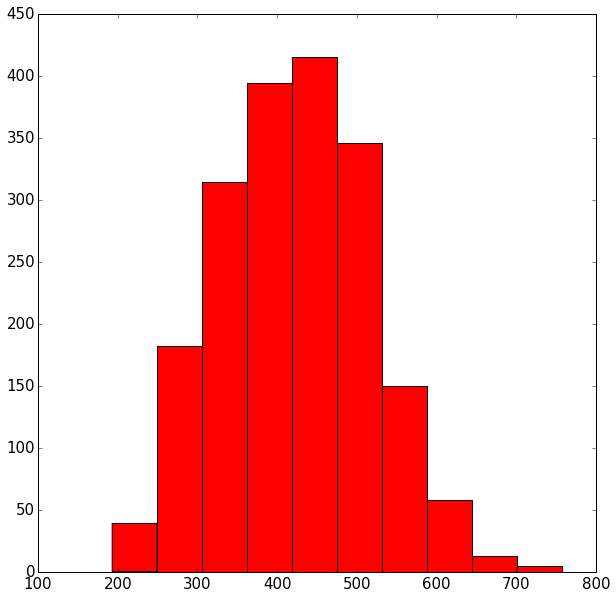

In [117]:
plt.hist(n_hits)

In [133]:
print memory_usage()
del data_2
print memory_usage()

[5353.91796875]
[4698.3984375]


In [ ]:
# TO ROOT ADVENTURE
# Current Format
# 1. Select good signal tracks
#   a. Apply timing cuts
#   b. Apply quality cuts
# 2. Use all background tracks
#   a. Apply timing cuts  
# 3. Deal with coincidence
#   a. overlay good signal on all background
#   b. sum the results
# 4. Apply algorithm 
#
# Need to produce following branches: 
#  From SimChen: 
#    1. Position CHECK
#    2. Momentum CHECK
#    3. "Truth" Seeds
#    4. Labels
#  From Me:
#    1. Scores
#    2. Seeds

In [ ]:
# TODO 
# Plots for Louis

# Penalize for not being the closest point to the fit



# Belle-II literature
# multiple radii
# optimize hough to improve track purity, use RANSAC to shed background islands
# 

#TODO Offline Analysis
# WEDS clean up RANSAC implimentation
# WEDS use shifted hough in RANSAC implimentation
# THURS penalize on no hits for RANSAC
# THURS change sampling probability via GBDT score
# THURS change scoring weight by GBDT score
# FRI check results for mulitple radii, no optimization
# FRI check results for varying hit efficiencies, no optimization


# In[73]:

#TODO Online
# TUES Rebuild notebook for new sample
# TUES Integrate trigger signal in
# TUES Reevaluate the flow of the algorithm


# In[74]:

# MC PRODUCTION
# Timing in Prod. Sec.
#  Determine IO and CPU time for current jobs
#  Determine best cuts to make (most obvious ones anyway)
# ECAL hits
#  After CM18
# Cross-Check occupancy
#  Generate large enough CyDet sample and check occupancy
#  Perhaps do this locally, or atleast the merging part


# In[75]:

# NOTES
## Shifting to align image in hough space must 
#  play well with the placticity already 
#  implimented in the algorithm.  Adjust reweighting
## Try reweighting background hits close to signal hits
#  as worse when we do the track level GBDT algo.  Rid
#  background islands at RANSAC level.

